In [58]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.text import text_to_word_sequence

Source used: https://www.kaggle.com/code/tabahjatmiko/sentiment-analysis-on-movie-review-tabah-jatmiko

In [5]:
#import zipfile
#with zipfile.ZipFile("../data/sentiment-analysis-on-movie-reviews.zip","r") as zip_ref:
 #   zip_ref.extractall("../data/sentiment-analysis-on-movie-reviews")

A tab-delimited file contains rows of data. Each row of data contains one or more pieces of data. Each piece of data is called a field. Tab-delimited files to be read by the Data Integrator must contain the same number of fields in every row, although not every field necessarily needs a value.

Before Data Integrator starts reading a tab-delimited file, the user assigns a module, business object, and form to the file. This information instructs the Data Integrator where the data in the file must go when uploaded.

In [2]:
import pandas as pd
train=pd.read_csv("../data/sentiment-analysis-on-movie-reviews/train.tsv.zip",sep='\t') #\t means  Tab-delimited file
test=pd.read_csv("../data/sentiment-analysis-on-movie-reviews/test.tsv.zip",sep='\t')

In [13]:
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [14]:
train.tail()

,PhraseId,SentenceId,Phrase,Sentiment
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2
156059,156060,8544,chortles,2


In [15]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


We are not interested in the description of the ids columns.

In [17]:
train['Sentiment'].describe()

count    156060.000000
mean          2.063578
std           0.893832
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: Sentiment, dtype: float64

In [20]:
train.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [21]:
test.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
dtype: int64

We can see that there's no NA value either in the train or in the test dataset.

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

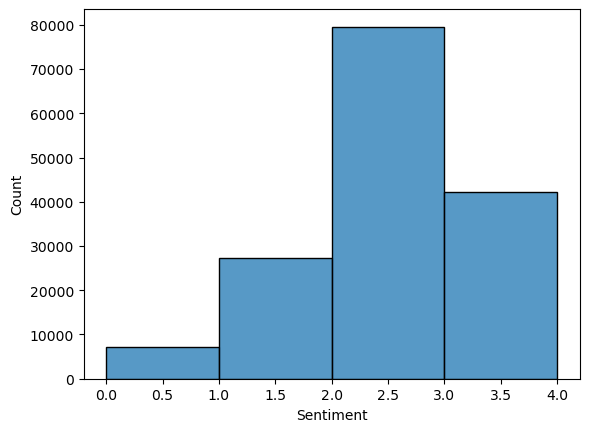

In [59]:
import seaborn as sns
sns.histplot(data=train,x='Sentiment',bins=4) # bins are the number of bars

### Data preprocessing 

In [3]:
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.preprocessing.text import text_to_word_sequence

from numba import jit, cuda



def TextPreprocessing(text):
    text=str(text)
    text = text.replace("'","")
    tokenized_train_data = text_to_word_sequence(text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=" ")
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_data if not i in stop_words]
    stopwordremove_text = ' '.join(stopwordremove)
    numberRemove = ''.join(num for num in stopwordremove_text if not num.isdigit())
    stemmer = PorterStemmer()
    stem_input = nltk.word_tokenize(numberRemove)
    stem_text = ' '.join([stemmer.stem(word) for word in stem_input])
    return stem_text

In [4]:
train2=train
train2['Phrase']=train['Phrase'].apply(TextPreprocessing)

In [58]:
train2

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,seri escapad demonstr adag good goos also good...,1
1,2,1,seri escapad demonstr adag good goos,2
2,3,1,seri,2
3,4,1,,2
4,5,1,seri,2
...,...,...,...,...
156055,156056,8544,hearst,2
156056,156057,8544,forc avuncular chortl,1
156057,156058,8544,avuncular chortl,3
156058,156059,8544,avuncular,2


In [5]:
train2['Phrase'].replace('',np.nan,inplace =True)
train2.dropna(subset = ['Phrase'],inplace =True)

In [6]:
train2.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,seri escapad demonstr adag good goos also good...,1
1,2,1,seri escapad demonstr adag good goos,2
2,3,1,seri,2
4,5,1,seri,2
5,6,1,escapad demonstr adag good goos,2


In [6]:
phrase = train2['Phrase']
sentiment = train2['Sentiment']

In [62]:
train_x,test_x,train_y,test_y = train_test_split(phrase,sentiment,test_size=0.2,random_state=2)

In [63]:
vectorizer = TfidfVectorizer()
tfidf_text = vectorizer.fit_transform(train_x)

In [42]:
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('knn', KNeighborsClassifier(n_neighbors=4, metric='euclidean')),
               ])

knn.fit(train_x, train_y)

test_predict = knn.predict(test_x)

train_accuracy = round(knn.score(train_x, train_y)*100)
test_accuracy =round(accuracy_score(test_predict, test_y)*100)

print("K-Nearest Neighbour Train Accuracy Score : {}% ".format(train_accuracy ))
print("K-Nearest Neighbour Test Accuracy Score  : {}% ".format(test_accuracy ))

K-Nearest Neighbour Train Accuracy Score : 74% 
K-Nearest Neighbour Test Accuracy Score  : 61% 


In [13]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [15]:
test['Phrase'] = test['Phrase'].apply(TextPreprocessing)

In [16]:
test_id = test['PhraseId']
test_text = test['Phrase']
y_prdict = knn.predict(test_text)

In [17]:
submission = pd.DataFrame(list(zip(test_id, y_prdict)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
5,156066,2
6,156067,2
7,156068,2
8,156069,2
9,156070,2


In [24]:
submission.groupby(['Sentiment']).count()

,PhraseId
Sentiment,
0,820
1,4989
2,54759
3,4885
4,839


<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

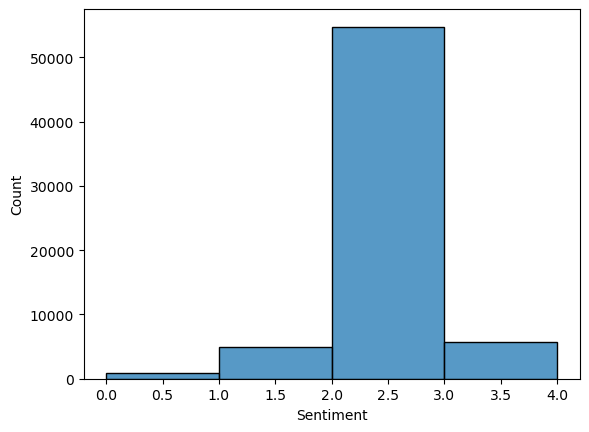

In [25]:
import seaborn as sns
sns.histplot(data=submission,x='Sentiment',bins=4)

#### Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
clf = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', MultinomialNB()),
               ])

clf.fit(train_x, train_y)



Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
test_predict = clf.predict(test_x)



In [41]:
train_accuracy = round(clf.score(train_x, train_y)*100)
test_accuracy =round(accuracy_score(test_predict, test_y)*100)

print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))


Naive Bayes Train Accuracy Score : 61% 
Naive Bayes Test Accuracy Score  : 63% 


#### Logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression
lgr = Pipeline([('tfidf', TfidfVectorizer()),
                ('lgr', LogisticRegression(penalty="l2",max_iter=1000)),
               ])

lgr.fit(train_x, train_y)
test_predict = lgr.predict(test_x)
train_accuracy = round(lgr.score(train_x, train_y)*100)
test_accuracy =round(accuracy_score(test_predict, test_y)*100)

print("Logistic Regression Train Accuracy Score : {}% ".format(train_accuracy ))
print("Logistic Regression Test Accuracy Score  : {}% ".format(test_accuracy ))


Logistic Regression Train Accuracy Score : 67% 
Logistic Regression Test Accuracy Score  : 63% 


#### Grid Search

In [65]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
grid_values = {'penalty': ['none', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')

In [72]:
from sklearn.model_selection import GridSearchCV
tfidf=TfidfVectorizer()
train_xv = tfidf.fit_transform(train_x)

In [76]:
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25],'max_iter':[500,1000]}
rid_clf_acc=GridSearchCV(LogisticRegression(), param_grid = grid_values,scoring = 'recall')
rid_clf_acc.fit(train_xv, train_y)
test_predict = rid_clf_acc.predict(test_x)
train_accuracy = round(rid_clf_acc.score(train_x, train_y)*100)
test_accuracy =round(accuracy_score(test_predict, test_y)*100)

print("Logistic Regression Train Accuracy Score : {}% ".format(train_accuracy ))
print("Logistic Regression Test Accuracy Score  : {}% ".format(test_accuracy ))


C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 219, in __call__
    return self._score(
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\metrics\_classification.py", line 1920, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

#### Deep learning model

https://www.kaggle.com/code/chiranjeevbit/movie-review-prediction

In [56]:
from keras.utils import to_categorical
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential


In [57]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(train_x))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)
test = tokenizer.texts_to_sequences(test)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

train_x = sequence.pad_sequences(train_x, maxlen=len_max)
test_x = sequence.pad_sequences(test_x, maxlen=len_max)
test = sequence.pad_sequences(test, maxlen=len_max)

print(train_x.shape,test_x.shape,test.shape)

AttributeError: 'int' object has no attribute 'lower'

In [48]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [50]:
from tqdm import tqdm
unique_words = set()
len_max = 0

for sent in tqdm(train_x):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)

100%|██████████████████████████████████████████████████████████████████████| 123739/123739 [00:00<00:00, 674999.46it/s]


In [51]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [52]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 188, 300)          8100      
                                                                 
 lstm (LSTM)                 (None, 188, 128)          219648    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 284,161
Trainable params: 284,161
Non-tr

C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [53]:
history=model.fit(train_x, train_y, validation_data=(test_x, test_y),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/6


ValueError: in user code:

    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\ALEX\miniconda3\envs\Python-data-wranglig\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 5) are incompatible


In [ ]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()